# Digit recognition

In [31]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
train_data = pd.read_csv('train.csv')

In [33]:
train_data.shape

(42000, 785)

### Preprocessing

separate the training data into images and labels

In [34]:
images = train_data.iloc[:, 1:]
labels = train_data.iloc[:, 0]

# reshape the images so we can use CNNs
labels = labels.as_matrix()
images = images.as_matrix().reshape(images.shape[0], 28, 28, 1)

#### Features normalisation

In [35]:
def normalize_grayscale(image_data):
    return (25.5 + 0.8 * image_data) / 255

train_features = normalize_grayscale(images)

one-hot encoding for labels

In [36]:
from keras.utils import np_utils
train_labels = np_utils.to_categorical(labels)

In [37]:
# divide data into training and validation set
from sklearn.model_selection import train_test_split
train_features, val_features, train_labels, val_labels = train_test_split(train_features, 
                                                                          train_labels, 
                                                                          test_size=0.15, 
                                                                          random_state=np.random.randint(300))

print('train_features shape: ', train_features.shape)
print('val_features shape: ', val_features.shape)
print('train_labels shape: ', train_labels.shape)
print('val_labels shape: ', val_labels.shape)

train_features shape:  (35700, 28, 28, 1)
val_features shape:  (6300, 28, 28, 1)
train_labels shape:  (35700, 10)
val_labels shape:  (6300, 10)


### Model

In [12]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.models import Model, load_model

def get_model(input_shape):
    
    drop = 0.3 
    X_input = Input(input_shape)
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', 
               kernel_initializer='glorot_normal')(X_input)
    X = MaxPooling2D((2,2))(X)  
    X = Conv2D(128, (5,5), strides=(1,1), activation='relu',
              kernel_initializer='glorot_normal')(X)    
    X = MaxPooling2D((2,2))(X)  
    X = Flatten()(X) 
    X = Dense(256, activation='relu')(X)
    X = Dropout(drop)(X) 
    X = Dense(32, activation='relu')(X)
    X = Dropout(drop)(X)  
    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    return model

In [13]:
from keras.optimizers import Nadam

model = get_model((28, 28, 1))

model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
__________

### Training

In [16]:
from keras.callbacks import ModelCheckpoint
f_path = 'model.h5'
msave = ModelCheckpoint(f_path, save_best_only=True)

In [17]:
epochs = 5
batch_size = 64
training = model.fit(train_features, train_labels,
                     validation_data=(val_features, val_labels),
                     epochs=epochs,
                     callbacks=[msave],
                     batch_size=batch_size, 
                     verbose=1)

Train on 30345 samples, validate on 5355 samples
Epoch 1/5
30345/30345 [==============================] - 77s 3ms/step - loss: 0.4039 - acc: 0.8752 - val_loss: 0.0993 - val_acc: 0.9709
Epoch 2/5
30345/30345 [==============================] - 78s 3ms/step - loss: 0.1490 - acc: 0.9605 - val_loss: 0.0849 - val_acc: 0.9757
Epoch 3/5
30345/30345 [==============================] - 84s 3ms/step - loss: 0.1082 - acc: 0.9708 - val_loss: 0.0564 - val_acc: 0.9847
Epoch 4/5
30345/30345 [==============================] - 85s 3ms/step - loss: 0.0846 - acc: 0.9773 - val_loss: 0.0679 - val_acc: 0.9847
Epoch 5/5
30345/30345 [==============================] - 83s 3ms/step - loss: 0.0775 - acc: 0.9796 - val_loss: 0.0506 - val_acc: 0.9862


### Graphics

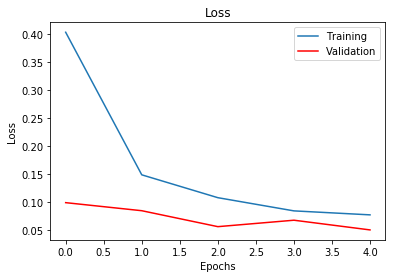

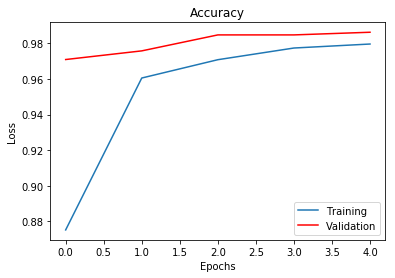

In [18]:
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

In [21]:
model = load_model(f_path)

test_data = pd.read_csv('test.csv')

# reshape the test_data
test_images = test_data.as_matrix().reshape(test_data.shape[0], 28, 28, 1)

# normalisation
test_features = normalize_grayscale(test_images)

# prediction
pred = model.predict(test_features, batch_size=batch_size, 
                       verbose=1)


C:\Users\Glowzer-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


28000/28000 [==============================] - 18s 634us/step


In [24]:
# convert predicions from categorical back to 0...9 digits
pred_digits = np.argmax(pred, axis=1)

pred_digits = pd.DataFrame({'Label': pred_digits})
pred_digits

,Label
0,2
1,0
2,9
3,9
4,3
5,7
6,0
7,3
8,0
9,3
